In [1]:
import matplotlib.pyplot as plt
import pickle
import os
import math
import numpy as np
from od.social import SocialGroup
from od.network.types import ResourceAllocatorType,BaseStationType
from od.misc.interest import InterestConfig
from od.misc.statistic import NetFlowType
from numpy import random
plt.rcParams.update(
    {
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "legend.loc":"upper left",
    "legend.framealpha":0.3,
    "font.size":14,
    }
)

In [2]:
def GetLineMarkerStyle(line_no):
    line_style = ['--','-.',':']
    marker_style = ['o','v','^','<','>','s','p','*','h','H','x','D']
    line_no = line_no % (len(line_style)*len(marker_style))
    return marker_style[int(line_no%len(marker_style))] + line_style[int(line_no/(len(marker_style)))]
#     return marker_style[int(line_no/len(line_style))] + line_style[int(line_no%(len(line_style)))]

In [3]:
nsg_graph_configs = [
    {
        "catalog": "bs_through_put",
        "topic": "Throughput",
        "x": "Traffic Scale",
        "y": "Megabits",
        "subject": [bs_type for bs_type in BaseStationType]
    },
    
]


In [4]:
bs_sg_graph_configs = [
    {
        "catalog": "bs_sg_res_use_rate",
        "topic": "Social-Group Traffic Service Ratio",
        "x": "Traffic Scale",
        "y": "%",
        "subject": [bs_type for bs_type in BaseStationType]
    },
]



In [5]:
sys_graph_configs = [
    {
        "catalog": "sys_through_put",
        "topic": "Throughput",
        "x": "Traffic Scale",
        "y": "Megabits",
    },
]

In [6]:
bs_names = {
    BaseStationType.UMA: "4G-eNB",
    BaseStationType.UMI: "5G-gNB",
}

In [7]:
def ExtractAbbreviations(abbrev):
    if(abbrev.lower() == "avg"):
        return "Average"
    elif(abbrev.lower() == "max"):
        return "Maximum"
    elif(abbrev.lower() == "min"):
        return "Minimum"

In [8]:
def BaseStationScenario(with_rsu):
    if(with_rsu):
        return "4G+5G"
    else:
        return  "4G"

In [9]:
seed_range = [6,7,8,9,10]
res_alloc_type_range = [t for t in ResourceAllocatorType]
req_rsu_range = [False, True]
traffic_scale_range = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]

In [10]:
import os
os.getcwd()

'/home/OD/repos/ProjectSumo'

In [11]:
interest_config = InterestConfig(None, False, 0)
stats = {
    seed:{
        res_alloc_type :{
            req_rsu:{
                traffic_scale: None 
                for traffic_scale in traffic_scale_range
            }
            for req_rsu in req_rsu_range
        }
        for res_alloc_type in res_alloc_type_range
    }
    for seed in seed_range
}
for seed in seed_range:
    for res_alloc_type in res_alloc_type_range:
        for req_rsu in req_rsu_range:
            for traffic_scale in traffic_scale_range:
                interest_config.res_alloc_type = res_alloc_type
                interest_config.req_rsu = req_rsu
                interest_config.traffic_scale = traffic_scale
                try:
                    with open("data/{}/{}/report.pickle".format(seed,str(interest_config)), "rb") as file:
                        stats[seed][res_alloc_type][req_rsu][traffic_scale] = pickle.load(file)
                except:
                    print("missing: {} seed({})".format(str(interest_config),seed))

In [12]:
# create picture folder
dirpath = "pics/"
if not os.path.isdir(dirpath):
    os.mkdir(dirpath)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


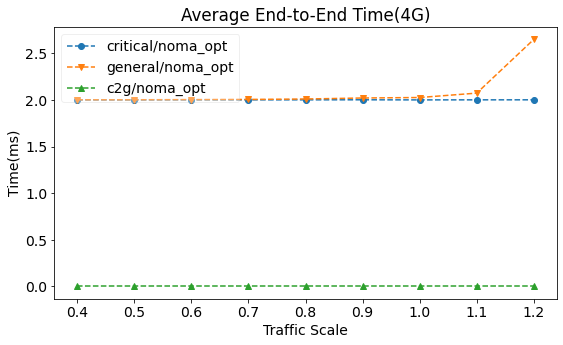

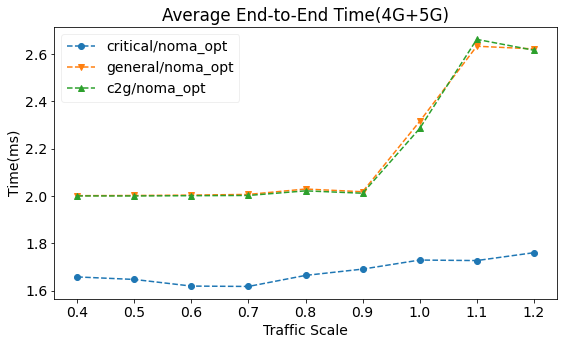

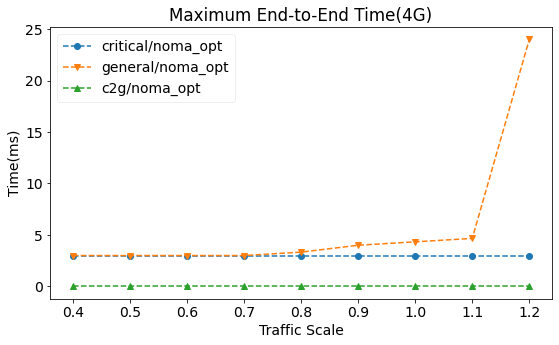

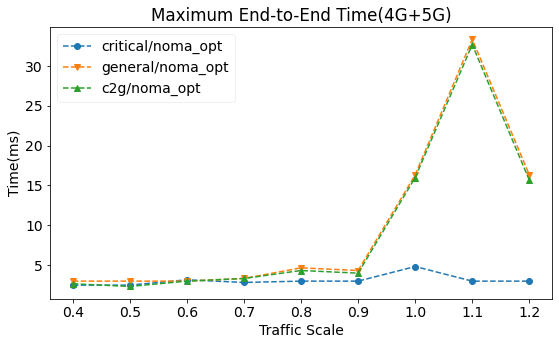

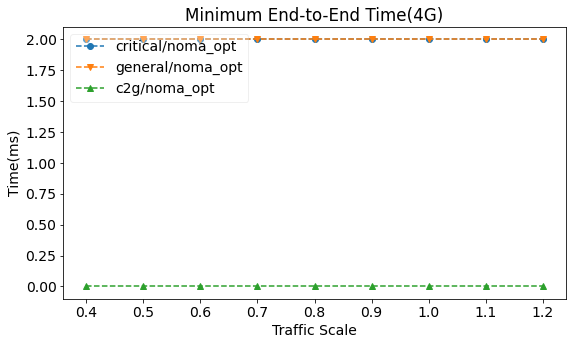

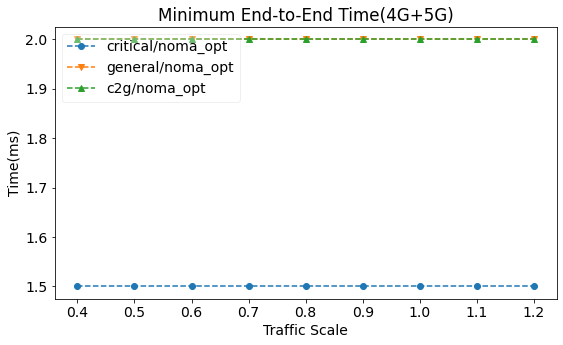

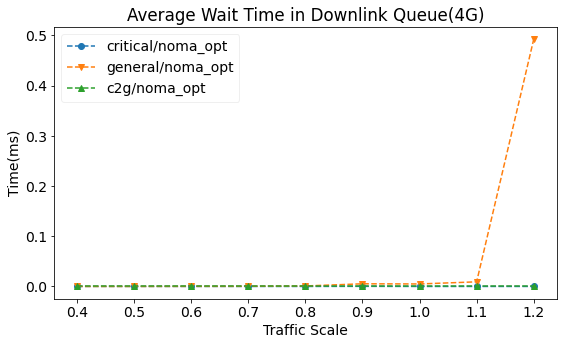

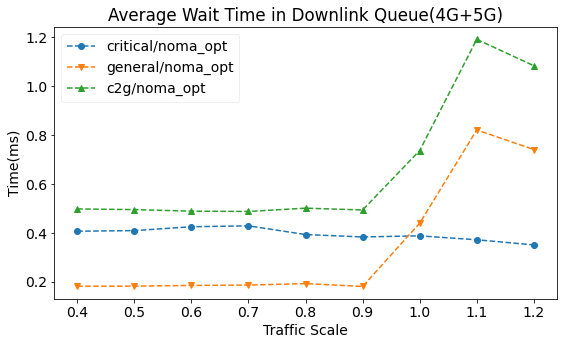

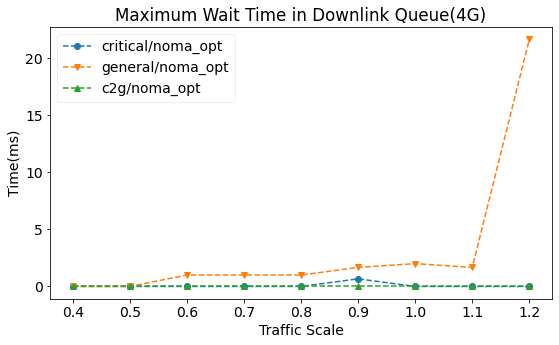

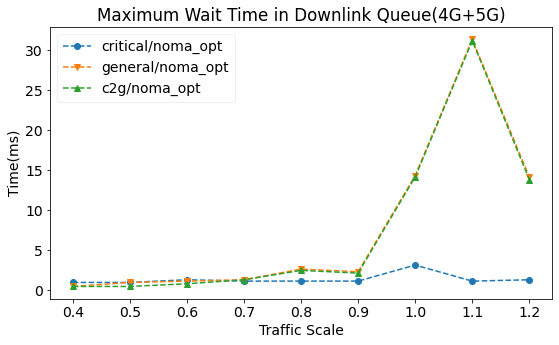

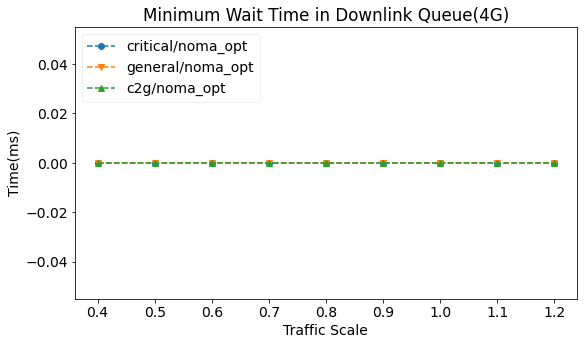

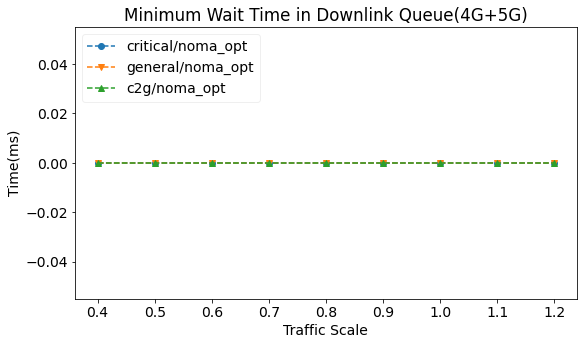

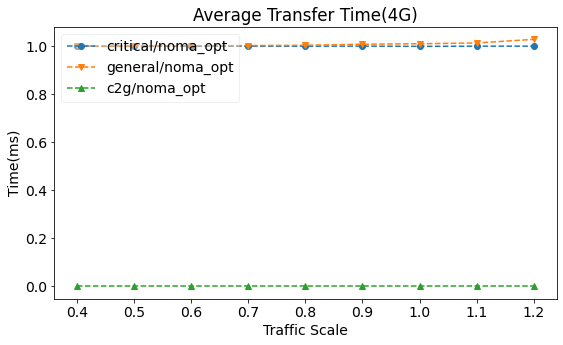

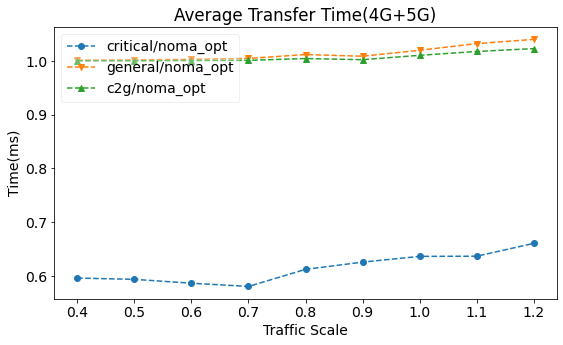

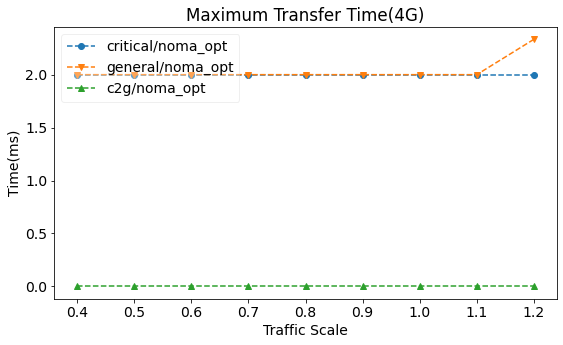

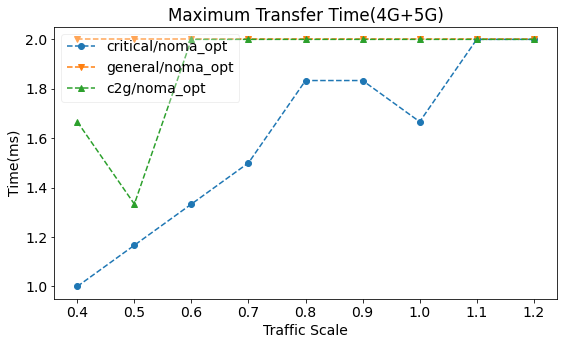

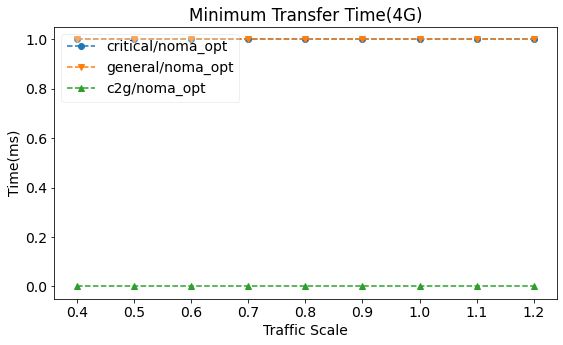

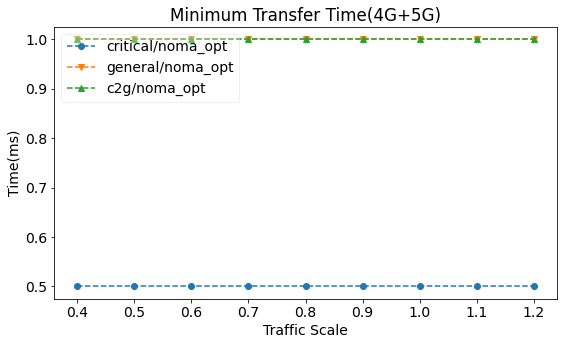

In [13]:
netflow_timing_report_configs = [
    {
        "catalog": "end-to-end",
        "topic": "End-to-End Time",
        "x": "Traffic Scale",
        "y": "Time(ms)",
        "subject": ["avg", "max", "min"]
    },
    {
        "catalog": "wait-time",
        "topic": "Wait Time in Downlink Queue",
        "x": "Traffic Scale",
        "y": "Time(ms)",
        "subject": ["avg", "max", "min"]
    },
    {
        "catalog": "tx-time",
        "topic": "Transfer Time",
        "x": "Traffic Scale",
        "y": "Time(ms)",
        "subject": ["avg", "max", "min"]
    },
]


# intialize
_pinf = float("inf")
_ninf = float("-inf")
serial = 1
for config in netflow_timing_report_configs:
    catalog = config["catalog"]
    topic = config["topic"]
    subjects = config["subject"]
    for subject in subjects:
        for req_rsu in req_rsu_range:
            title = "{} {}({})".format(
                ExtractAbbreviations(subject), 
                topic,
                BaseStationScenario(req_rsu)
            )
            plt.figure(serial, figsize=(9, 5))
            plt.xlabel(config["x"])
            plt.ylabel(config["y"])
            plt.title(title)
            line_no = 0
            for res_alloc_type in [ResourceAllocatorType.NOMA_OPT]:
                for nft in NetFlowType:
                    y = []
                    x = traffic_scale_range
                    for traffic_scale in traffic_scale_range:
                        value = []
                        for seed in seed_range:
                            v = stats[seed][res_alloc_type][req_rsu][traffic_scale][catalog][nft.name][subject]
                            if v == _pinf or v == _ninf:
                                v = 0
                            value.append(v*1000)
                        value.sort()
                        value = value[1:-1]
                        y.append(sum(value)/len(value))
                    plt.plot(
                        x,
                        y,
                        GetLineMarkerStyle(line_no),
                        label="{}/{}".format(
                              nft.name.lower(),
                              res_alloc_type.name.lower(),
                        )
                    )
                    line_no += 1
            plt.legend(loc='upper left', bbox_to_anchor=(0, 1))
            plt.savefig('{}/{}.pdf'.format(dirpath, title))
            serial += 1
plt.show()


In [49]:
 for traffic_scale in traffic_scale_range:
    value = []
    for seed in seed_range:
        v = stats[seed][ResourceAllocatorType.NOMA_OPT][True][1.1]["end-to-end"][NetFlowType.GENERAL.name]["max"]
        if v == _pinf or v == _ninf:
            v = 0
        value.append(v*1000)
    value.sort()
    value = value
print(value)

[9.999999999990905, 15.00000000001478, 38.000000000010914, 46.999999999997044, 46.999999999997044]


In [50]:
 for traffic_scale in traffic_scale_range:
    value = []
    for seed in seed_range:
        v = stats[seed][ResourceAllocatorType.NOMA_OPT][True][1.2]["end-to-end"][NetFlowType.GENERAL.name]["max"]
        if v == _pinf or v == _ninf:
            v = 0
        value.append(v*1000)
    value.sort()
    value = value
print(value)

[6.000000000000227, 8.000000000009777, 18.000000000000682, 23.000000000024556, 25.000000000005684]


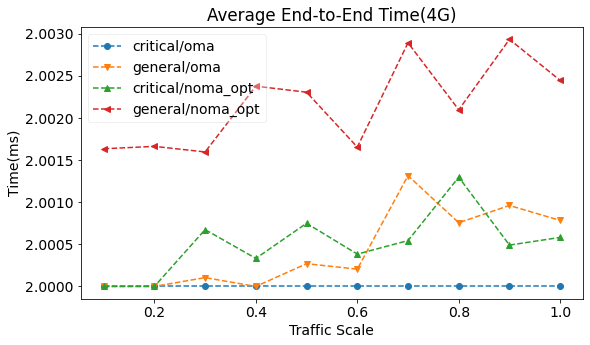

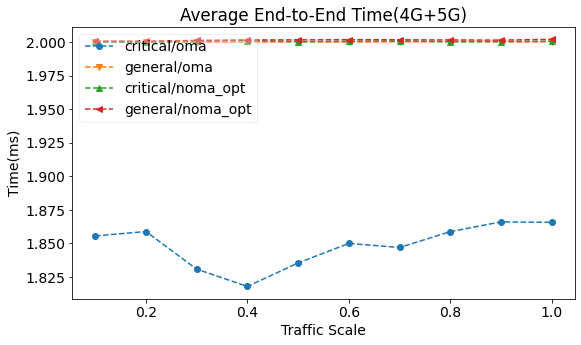

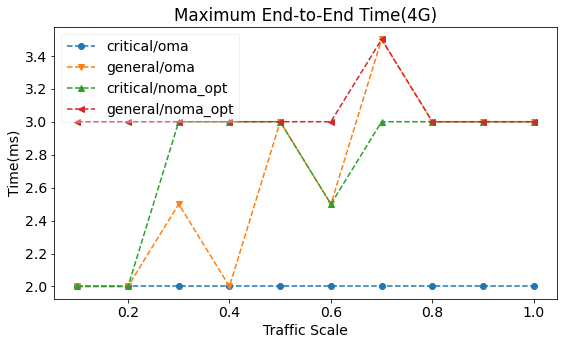

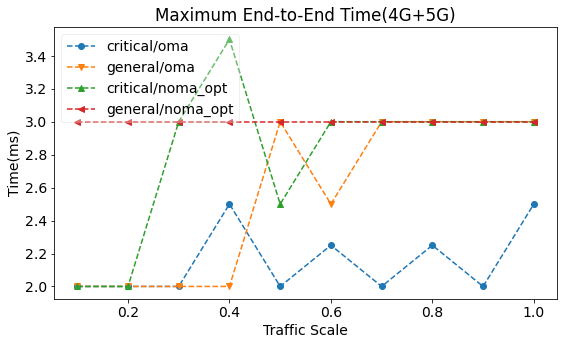

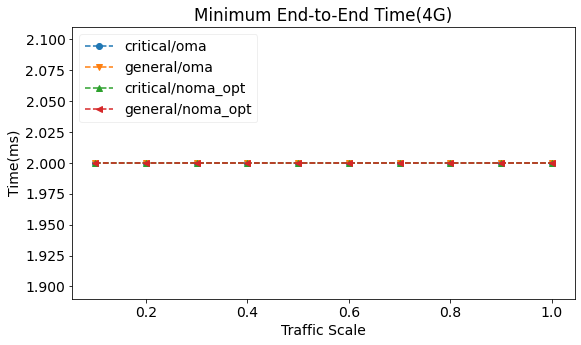

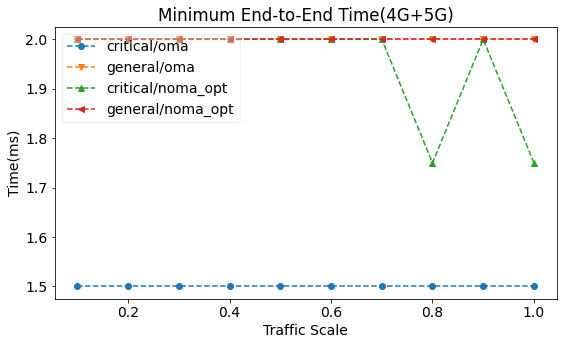

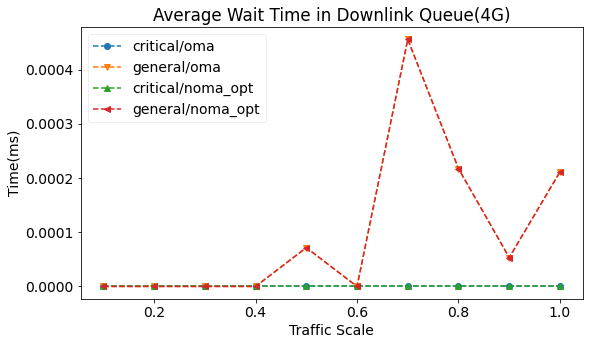

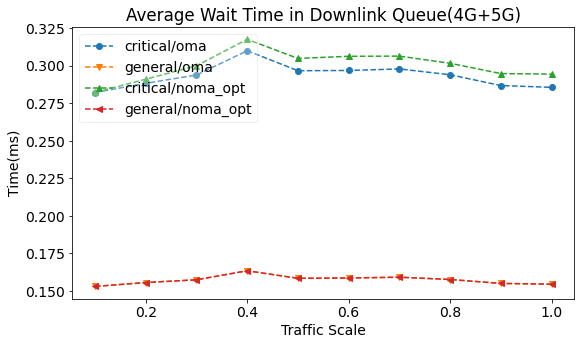

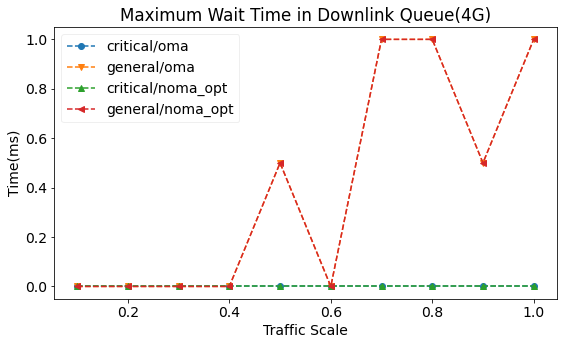

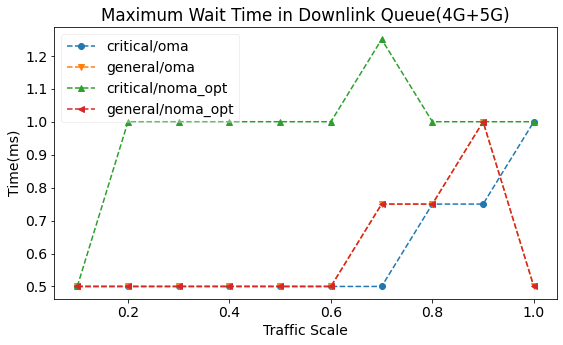

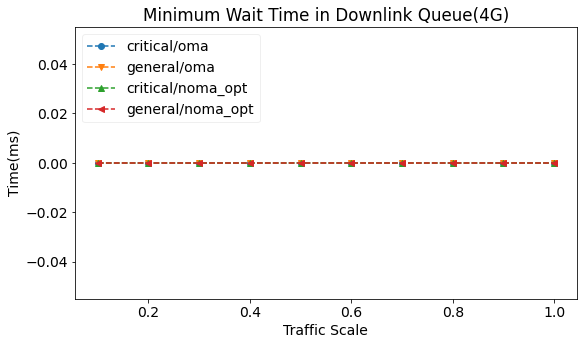

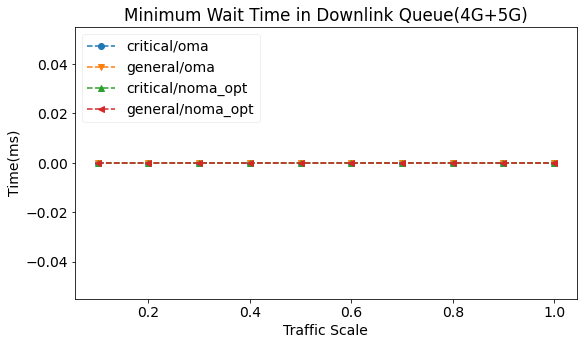

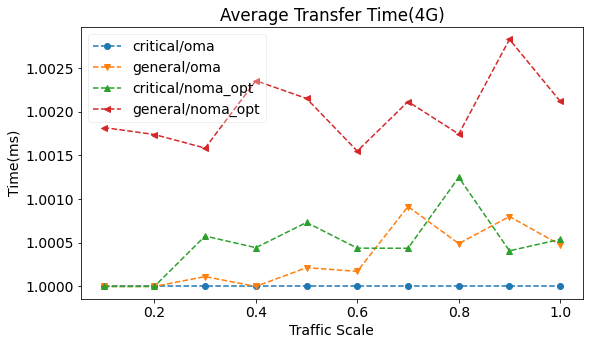

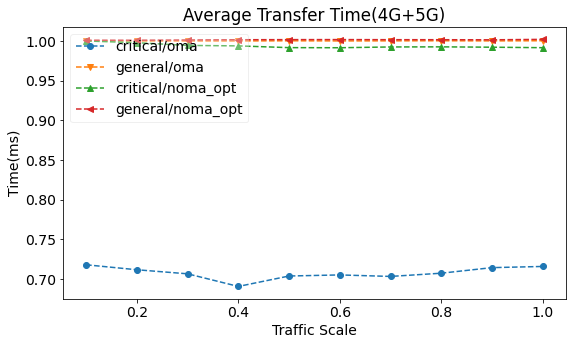

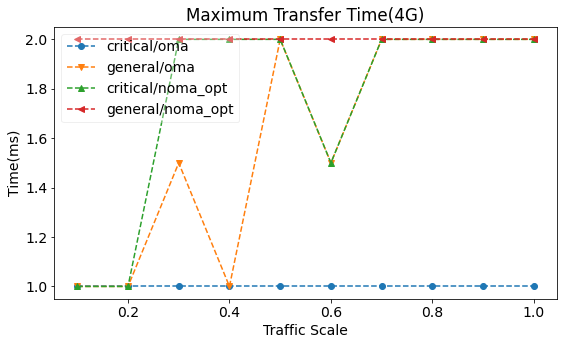

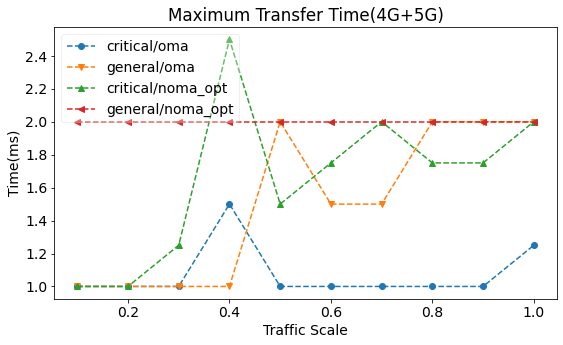

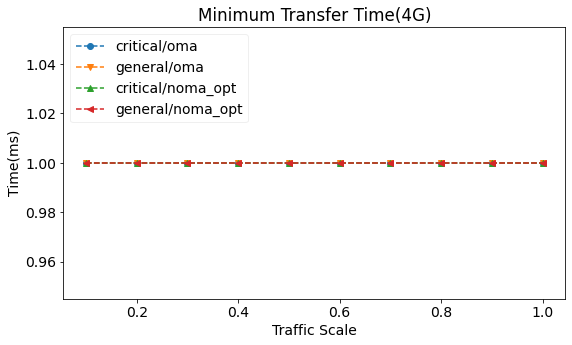

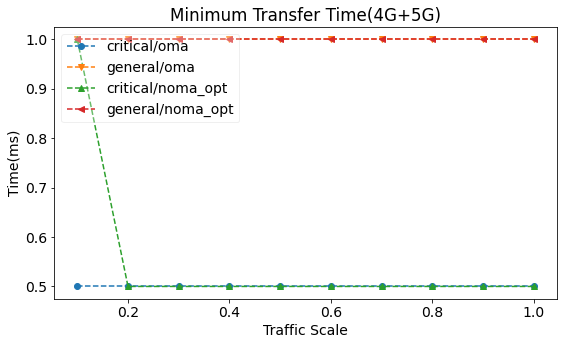

In [31]:
# intialize
_pinf = float("inf")
_ninf = float("-inf")
serial = 1
for config in sg_graph_configs:
    catalog = config["catalog"]
    topic = config["topic"]
    
    
    
    for subject in subjects:
        for _b in range(len(b)):
            title = "{} {}({})".format(
                ExtractAbbreviations(subject), 
                topic,
                BaseStationScenario(b[_b])
            )
            plt.figure(serial, figsize=(9, 5))
            plt.xlabel(config["x"])
            plt.ylabel(config["y"])
            plt.title(title)
            line_no = 0
            for _a in range(len(a)):
                for sg in SocialGroup:
                    y = []
                    x = c
                    for _c in range(len(c)):
                        value = 0
                        for _s in range(len(s)):
                            v = stats[_s][_a][_b][_c][catalog][sg][subject.lower()]
                            if v == _pinf or v == _ninf:
                                v = 0
                            value += v
                        y.append(value/len(s))
                    plt.plot(
                        x,
                        y,
                        GetLineMarkerStyle(line_no),
                        label="{}/{}".format(
                              str(sg).lower(),
                              a[_a].name.lower(),
                        )
                    )
                    line_no += 1
            plt.legend(loc='upper left', bbox_to_anchor=(0, 1))
            plt.savefig('{}/{}.pdf'.format(dirpath, title))
            serial += 1
plt.show()


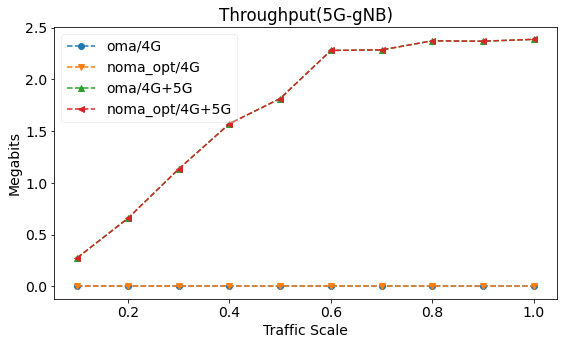

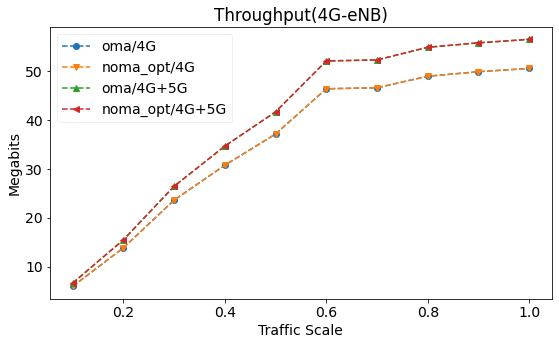

In [30]:
# intialize
_pinf = float("inf")
_ninf = float("-inf")
serial = 1
for config in nsg_graph_configs:
    catalog = config["catalog"]
    topic = config["topic"]
    subjects = config["subject"]
    for subject in subjects:
        title = "{}({})".format(
            topic, 
            bs_names[subject]
        )
        plt.figure(serial, figsize=(9, 5))
        plt.xlabel(config["x"])
        plt.ylabel(config["y"])
        plt.title(title)
        line_no = 0
        for _b in range(len(b)):
            for _a in range(len(a)):
                y = []
                x = c
                for _c in range(len(c)):
                    value = 0
                    for _s in range(len(s)):
                        v = stats[_s][_a][_b][_c][catalog][subject]
                        if v == _pinf or v == _ninf:
                            v = 0
                        value += v
                    
                    y.append((value/len(s))/10**6)
                plt.plot(
                    x,
                    y,
                    GetLineMarkerStyle(line_no),
                    label="{}/{}".format(
                        a[_a].name.lower(),
                        BaseStationScenario(b[_b])
                    )
                )
                line_no += 1
        plt.legend(loc='upper left', bbox_to_anchor=(0, 1))
        plt.savefig('{}/{}.pdf'.format(dirpath, title))
        serial += 1
plt.show()


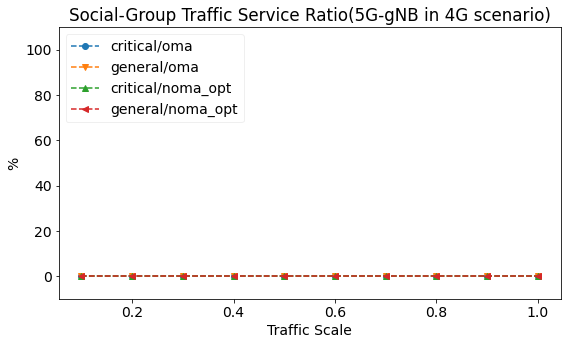

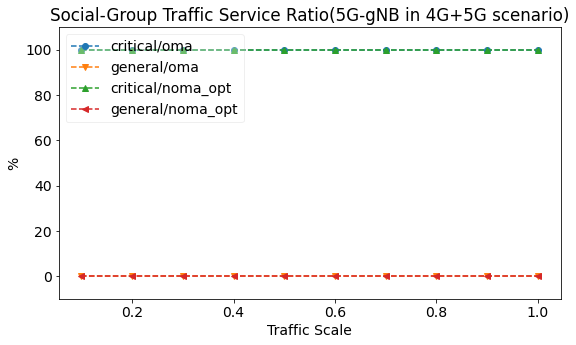

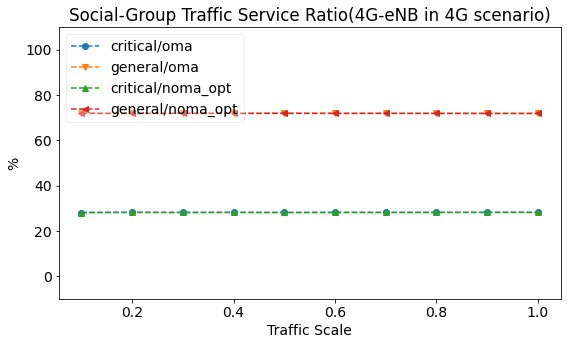

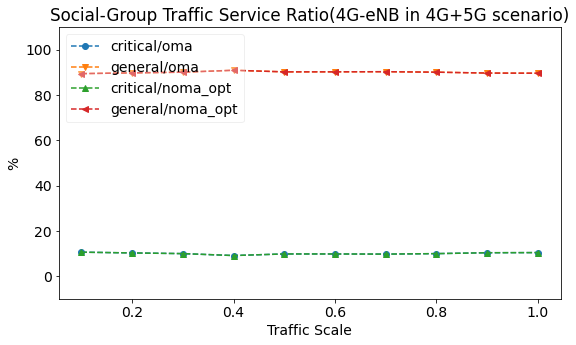

In [27]:
# intialize
_pinf = float("inf")
_ninf = float("-inf")
serial = 1

for config in bs_sg_graph_configs:
    catalog = config["catalog"]
    topic = config["topic"]
    subjects = config["subject"]
    for subject in subjects:
        # print("subject:{}".format(subject.name))
        for _b in range(len(b)):
            title = "{}({} in {} scenario)".format(
                    topic,
                    bs_names[subject],
                    BaseStationScenario(b[_b])
            )
            plt.figure(serial, figsize=(9, 5))
            plt.xlabel(config["x"])
            plt.ylabel(config["y"])
            plt.title(title)
            line_no = 0
            for _a in range(len(a)):
                for sg in SocialGroup:
                    y = []
                    x = c
                    for _c in range(len(c)):
                        value = 0
                        for _s in range(len(s)):
                            v = stats[_s][_a][_b][_c][catalog][subject][sg]
                            if v == _pinf or v == _ninf:
                                v = 0
                            value += v
                        y.append(value/len(s) * 100)
                    plt.plot(
                        x,
                        y,
                        GetLineMarkerStyle(line_no),
                        label="{}/{}".format(
                              str(sg).lower(),
                              a[_a].name.lower(),
                        )
                    )
                    line_no += 1
            plt.ylim([-10,110])
            plt.legend(loc='upper left', bbox_to_anchor=(0, 1))
            plt.savefig('{}/{}.pdf'.format(dirpath, title))
            serial += 1
plt.show()


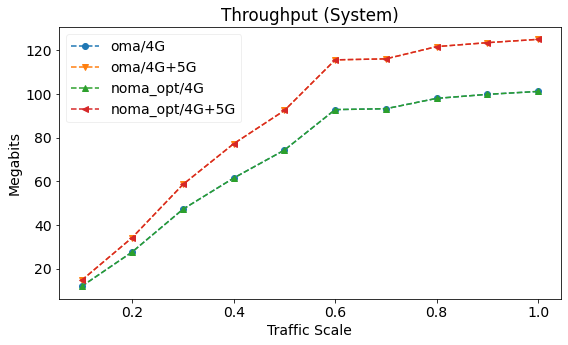

In [28]:
# intialize
_pinf = float("inf")
_ninf = float("-inf")
serial = 1

for config in sys_graph_configs:
    catalog = config["catalog"]
    topic = config["topic"]
    title = "{} (System)".format(topic)
    plt.figure(serial, figsize=(9, 5))
    plt.xlabel(config["x"])
    plt.ylabel(config["y"])
    plt.title(title)
    line_no = 0
    for _a in range(len(a)):
        for _b in range(len(b)):
            y = []
            x = c
            for _c in range(len(c)):
                value = 0
                for _s in range(len(s)):
                    v = stats[_s][_a][_b][_c][catalog]
                    if v == _pinf or v == _ninf:
                        v = 0
                    value += v
                y.append(value/len(s)/10**6)
            plt.plot(
                x,
                y,
                GetLineMarkerStyle(line_no),
                label="{}/{}".format(
                    a[_a].name.lower(),
                    BaseStationScenario(b[_b])
                )
            )
            line_no += 1
    plt.legend(loc='upper left', bbox_to_anchor=(0, 1))
    plt.savefig('{}/{}.pdf'.format(dirpath, title))
    serial += 1
plt.show()
